In [ ]:
!pip install pydicom

In [ ]:
import numpy as np
import pandas as pd
import pydicom as dicom
import os
import scipy.ndimage
import matplotlib.pyplot as plt
import torch

##The Hounsfield Unit (HU)
The Hounsfield Unit (HU) is a standardized scale used in medical imaging, particularly in computed tomography (CT) scans, to quantify the radiodensity of tissues within the body. It was introduced by Sir Godfrey Hounsfield, the inventor of the CT scanner.

The Hounsfield Unit scale is a numerical scale where water has a value of 0 Hounsfield Units, and values are assigned to different tissues based on their relative radiodensity compared to water. For example, tissues that are denser than water (such as bone) will have positive Hounsfield Unit values, while less dense tissues (like air-filled spaces) will have negative values.

Here are some common examples of tissues and their corresponding Hounsfield Unit values:

Air: Approximately -1000 HU
Water: 0 HU
Fat: Around -50 to -100 HU
Soft tissues (e.g., muscles, organs): Typically between 20 to 100 HU
Blood: About 30 to 70 HU
Bone: Much higher values, ranging from a few hundred to over a thousand HU
The Hounsfield Unit scale is crucial in interpreting CT scans, as it allows radiologists and other healthcare professionals to differentiate between different types of tissues and detect abnormalities. For instance, it helps identify fractures in bones, locate tumors, assess the presence of fluid or air in body cavities, and more.

Keep in mind that while the Hounsfield Unit scale is a valuable tool in medical imaging, it is not a direct measurement of tissue composition. Instead, it provides a relative measure of radiodensity that helps in the interpretation of images.

In [ ]:
def get_pixels_hu(slices):
    image = np.stack([s.pixel_array for s in slices])
    # Convert to int16 (from sometimes int16),
    # should be possible as values should always be low enough (<32k)
    image = image.astype(np.int16)

    # Set outside-of-scan pixels to 0
    # The intercept is usually -1024, so air is approximately 0
    image[image == -2000] = 0

    # Convert to Hounsfield units (HU)
    for slice_number in range(len(slices)):

        intercept = slices[slice_number].RescaleIntercept
        slope = slices[slice_number].RescaleSlope

        if slope != 1:
            image[slice_number] = slope * image[slice_number].astype(np.float64)
            image[slice_number] = image[slice_number].astype(np.int16)

        image[slice_number] += np.int16(intercept)

    return np.array(image, dtype=np.int16)


# Load the scans in given folder path
def load_scan(patient_id):
    a = [f for f in os.listdir(f'{input_folder}/{patient_id}') if f[0] != '.'][0]
    b = [f for f in os.listdir(f'{input_folder}/{patient_id}/{a}') if f[0] != '.'][0]
    path = f'{input_folder}/{patient_id}/{a}/{b}'
    ls = [f'{path}/{f}' for f in os.listdir(f'{input_folder}/{patient_id}/{a}/{b}') if f[0] != '.']
    ls.sort()
    slices = [dicom.read_file(s) for s in ls]
    slices.sort(key = lambda x: int(x.ImagePositionPatient[2]))
    try:
        slice_thickness = np.abs(slices[0].ImagePositionPatient[2] - slices[1].ImagePositionPatient[2])
    except:
        slice_thickness = np.abs(slices[0].SliceLocation - slices[1].SliceLocation)

    for s in slices:
        s.SliceThickness = slice_thickness
    return slices

In [ ]:
input_folder='/Volumes/TEST'
# Loads the patients folder names (which are also the patient Ids)
patients = [f for f in os.listdir(input_folder) if f[0] != '.']
patients.sort()

In [ ]:
stacked_x = []
for patient_id in patients:
    patient_slices = load_scan(patient_id) # Reads the dicom files
    stacked_slices = get_pixels_hu(patient_slices) # Convert to Hounsfield Unit
    stacked_x.append(torch.tensor(stacked_slices)) # Stacking the images to make a 4D tensor

stacked_x = np.array(torch.stack(stacked_x))
stacked_x.shape

(1, 372, 512, 512)

In [1]:
# testing for one patient
patient_id = 'AMC-015'

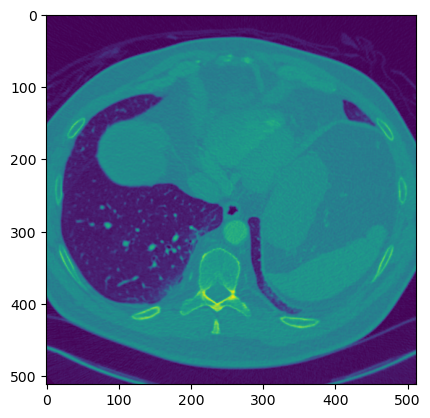

In [ ]:
plt.imshow(stacked_x[0,30,:,:])

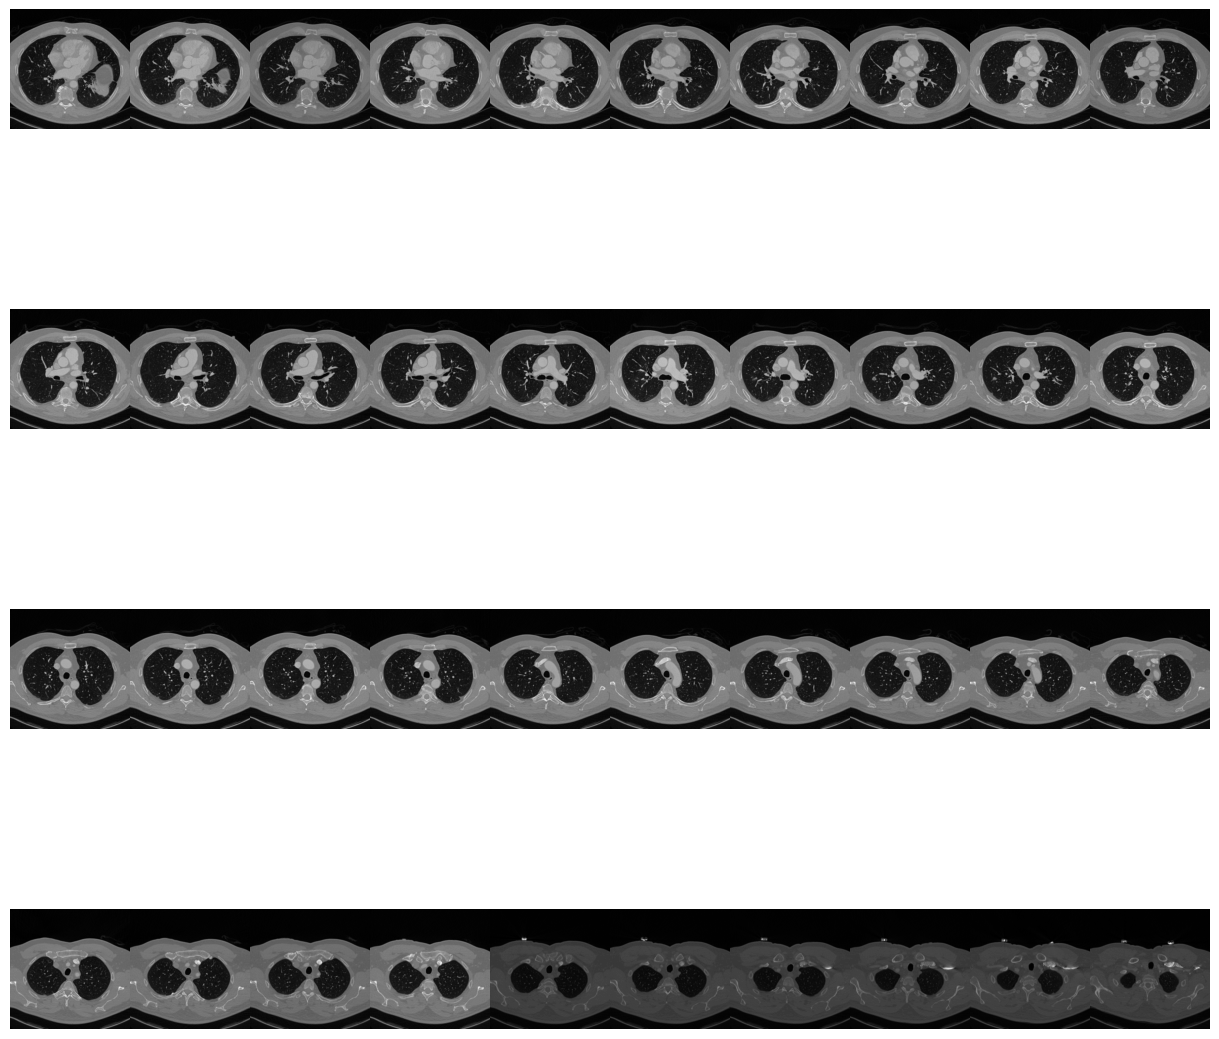

In [ ]:
f, axarr = plt.subplots(
        4,
        10,
        figsize=(12.0, 12.0),
        gridspec_kw={"height_ratios": [4,4,4,4]},
    )
a=100
for i in range(4):
        for j in range(10):
            axarr[i, j].imshow(stacked_x[0,a,:,:], cmap="gray")
            a+=6
            axarr[i, j].axis("off")
plt.subplots_adjust(wspace=0, hspace=0, left=0, right=1, bottom=0, top=1)
plt.show()

In [ ]:
a = [f for f in os.listdir(f'{input_folder}/{patient_id}') if f[0] != '.'][0]
b = [f for f in os.listdir(f'{input_folder}/{patient_id}/{a}') if f[0] != '.'][0]
path = f'{input_folder}/{patient_id}/{a}/{b}'
ls = [f'{path}/{f}' for f in os.listdir(f'{input_folder}/{patient_id}/{a}/{b}') if f[0] != '.']
ls.sort()
ls

['/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-001.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-002.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-003.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-004.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-005.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-006.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-007.dcm',
 '/Volumes/TEST/AMC-015/02-04-1992-NA-CT ANGIO THORAX-69413/5.000000-Gated Chest  1.0  B25f  BestDiast 70 -68007/1-008.dcm',
